In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [32]:
def f(x):
    return 3*x**2 - 4*x + 5

In [33]:
f(3)

20

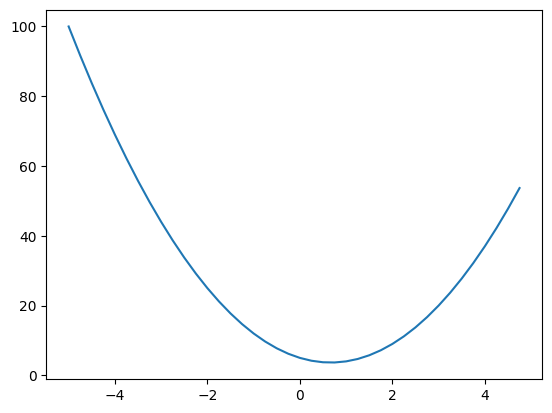

In [34]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [35]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [36]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [37]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [38]:
class Value():
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    
    def backward(self):
        self.grad = 1
        
        visited = set()
        topo = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for v in reversed(topo):
            v._backward()


In [39]:
a = Value(2)
a ** 2

Value(data=4)

In [40]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [41]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [42]:
o.backward()

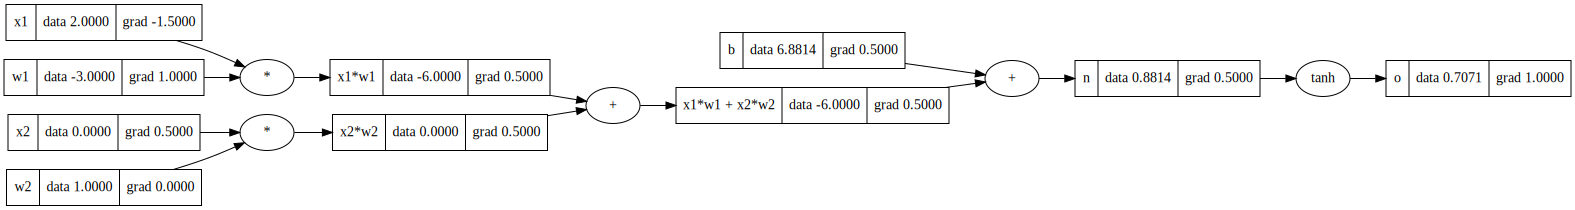

In [43]:
draw_dot(o)

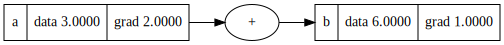

In [44]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

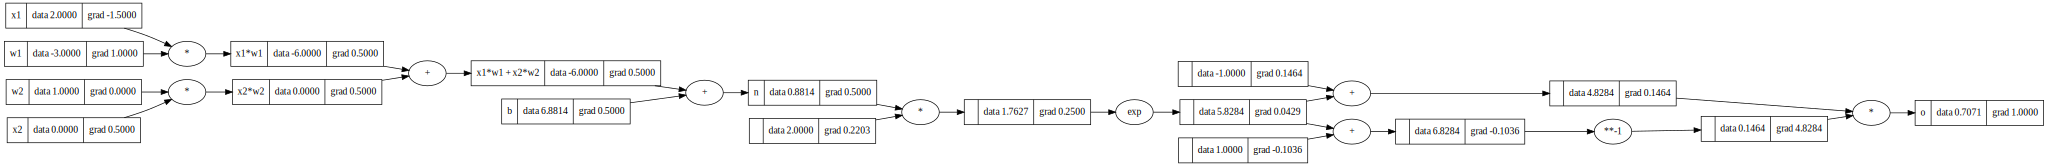

In [45]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [46]:
from typing import Any


class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        out = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = out.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.n = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.n]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.n for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.l = [Layer(sz[i], sz[i + 1]) for i in range(len(nout))]

    def __call__(self, x):
        for layer in self.l:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.l for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
out = n(x)

In [47]:
len(n.parameters())

41

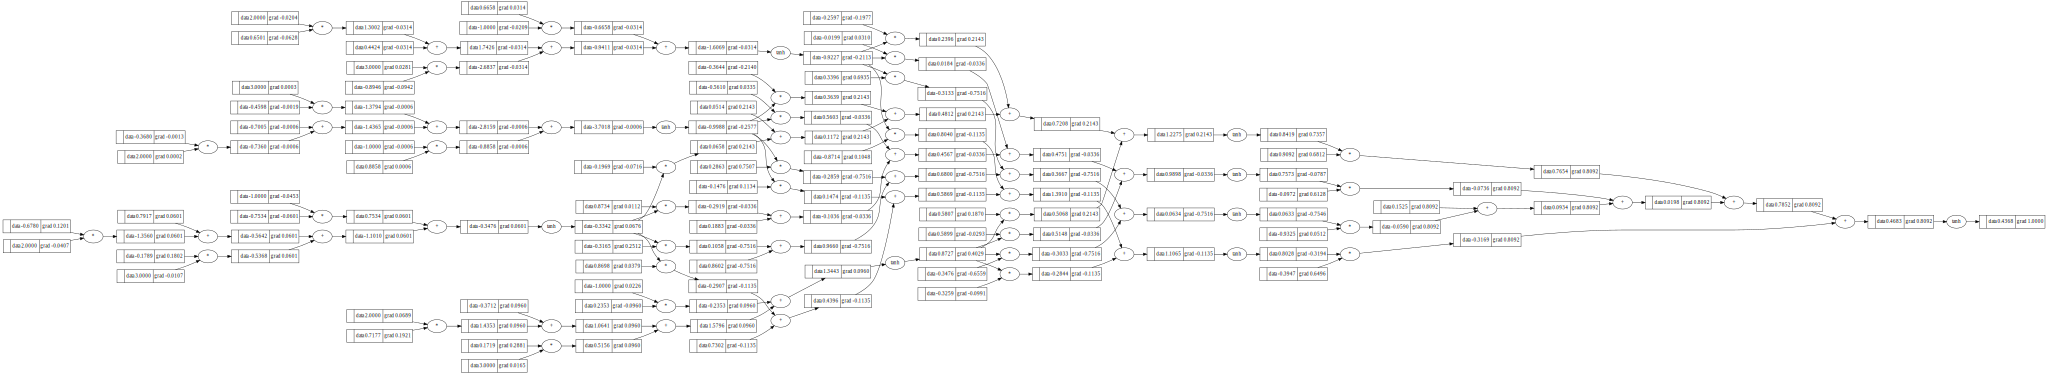

In [48]:
out.backward()
draw_dot(out)

In [55]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [62]:
for k in range(100):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.003808081336517685
1 0.0037720887710503527
2 0.0037367506687180497
3 0.0037020494753288104
4 0.0036679682581231433
5 0.0036344906784835304
6 0.0036016009660724065
7 0.003569283894312619
8 0.0035375247571288854
9 0.0035063093468753943
10 0.003475623933379496
11 0.003445455244035653
12 0.0034157904448890715
13 0.0033866171226515757
14 0.003357923267596592
15 0.003329697257283622
16 0.0033019278410650137
17 0.0032746041253319995
18 0.0032477155594587363
19 0.00322125192240618
20 0.0031952033099498104
21 0.0031695601224974593
22 0.0031443130534659224
23 0.0031194530781861263
24 0.0030949714433094236
25 0.0030708596566885018
26 0.0030471094777082693
27 0.0030237129080437496
28 0.003000662182822578
29 0.0029779497621723054
30 0.0029555683231322237
31 0.0029335107519123035
32 0.002911770136481209
33 0.002890339759467829
34 0.002869213091360418
35 0.002848383783989124
36 0.0028278456642782577
37 0.002807592728255141
38 0.0027876191353034814
39 0.002767919202649621
40 0.0027484874000707113


In [63]:
ypred

[Value(data=0.9811649659814357),
 Value(data=-0.9754859607088129),
 Value(data=-0.9771548065045219),
 Value(data=0.9785684344962271)]